In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import sympy as sp
from scipy.optimize import root
from sympy import symbols, diff
from matplotlib.patches import FancyArrowPatch
from matplotlib.legend_handler import HandlerPatch
from matplotlib.colors import ListedColormap, Normalize
import matplotlib as mpl

# Turing island identification

In [ ]:
def compute_ss_region(params, xmin, xmax, ymin, ymax, factor): #The factor is the resolution of the image
    xval = np.linspace(xmin, xmax, int((xmax - xmin) * factor))
    yval = np.linspace(ymin, ymax, int((ymax - ymin) * factor))
    X, Y = np.meshgrid(xval, yval)
    ss_a_region = np.zeros_like(X)
    ss_b_region = np.zeros_like(X)
    b_a, v_a, k_a,a,b, k_ba, mu_a = symbols('b_a v_a k_a a b k_ba mu_a', real=True)
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a) ** 2) * 1 / (1 + (b / k_ba) ** 2) - mu_a * a
    b_b, v_b, k_ab,a,b, mu_b = symbols('b_b v_b k_ab a b mu_b', real=True)
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b
    r_d_a_a = diff(r_d_a, a)
    r_d_a_b = diff(r_d_a, b)

    r_d_b_b = diff(r_d_b, b)
    r_d_b_a = diff(r_d_b, a)
    
    mod_pars = params[2:]
    values_base = {
        b_a: mod_pars[3], v_a: mod_pars[0], k_ba: mod_pars[2], mu_a: mod_pars[5],
        b_b: mod_pars[4], v_b: mod_pars[1], mu_b: mod_pars[6] # Fixed values
    }
    D_a = params[0]
    D_b = params[1]
    
    for i, k_a_val in enumerate(xval):
        for j, k_ab_val in enumerate(yval):
            values = values_base.copy()
            values[k_a] = k_a_val
            values[k_ab] = k_ab_val
            ss = solve_ss(k_a_val, k_ab_val, params)
            ss_a_region[j,i] = ss[0]
            ss_b_region[j,i] = ss[1]
    return X, Y, ss_a_region,ss_b_region
        
def compute_turing_region(params, xmin, xmax, ymin, ymax, factor,ss_a_region, ss_b_region): #The factor is the resolution of the image
    xval = np.linspace(xmin, xmax, int((xmax - xmin) * factor))
    yval = np.linspace(ymin, ymax, int((ymax - ymin) * factor))
    X, Y = np.meshgrid(xval, yval)
    Turing_region = np.zeros_like(X)
    b_a, v_a, k_a,a,b, k_ba, mu_a = symbols('b_a v_a k_a a b k_ba mu_a', real=True)
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a) ** 2) * 1 / (1 + (b / k_ba) ** 2) - mu_a * a
    b_b, v_b, k_ab,a,b, mu_b = symbols('b_b v_b k_ab a b mu_b', real=True)
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b
    r_d_a_a = diff(r_d_a, a)
    r_d_a_b = diff(r_d_a, b)

    r_d_b_b = diff(r_d_b, b)
    r_d_b_a = diff(r_d_b, a)
    
    mod_pars = params[2:]
    values_base = {
        b_a: mod_pars[3], v_a: mod_pars[0], k_ba: mod_pars[2], mu_a: mod_pars[5],
        b_b: mod_pars[4], v_b: mod_pars[1], mu_b: mod_pars[6] # Fixed values
    }
    D_a = params[0]
    D_b = params[1]
    
    for i, k_a_val in enumerate(xval):
        for j, k_ab_val in enumerate(yval):
            values = values_base.copy()
            values[k_a] = k_a_val
            values[k_ab] = k_ab_val
            ss2 = solve_ss2(k_a_val, k_ab_val, params,[ss_a_region[j,i],ss_b_region[j,i]])
            values[a] = ss2[0]
            values[b] = ss2[1]
            J = np.array([
                [r_d_a_a.subs(values).evalf(), r_d_a_b.subs(values).evalf()],
                [r_d_b_a.subs(values).evalf(), r_d_b_b.subs(values).evalf()]
            ], dtype=float)
            real_lambda = []
            k_values = np.linspace(0,2,100)
            for k in k_values:
                J_diff = J - np.diag([D_a * k**2, D_b * k**2])
                eig_vals = np.real(np.linalg.eigvals(J_diff))
                max_real_lambda = np.max(eig_vals)
                real_lambda.append(max_real_lambda)
            lambda_0 = real_lambda[0]
            lambda_max = max(real_lambda)
            index_max = np.argmax(real_lambda)
            # Proper Turing instability
            if lambda_max > 0 and lambda_0 < 0 and index_max != 0:
                Turing_region[j, i] = lambda_max
            else:
                Turing_region[j, i] = -1
    return X, Y, Turing_region

X, Y, ss_a_region,ss_b_region = compute_ss_region(params, 0, 30, 15,50, 6)
X, Y, Turing_region = compute_turing_region(params, 0, 30, 15,50, 6,ss_a_region,ss_b_region)
np.savez('turing_region.npz', X=X, Y=Y, Turing_region=Turing_region,ss_a_region = ss_a_region,ss_b_region = ss_b_region)


In [9]:
tr = np.load('turing_region.npz')
X = tr['X']
Y = tr['Y']
Turing_region = tr['Turing_region']

# Steady state solvers and approximators
The follwoing contains the steady state solver and the approximator for pattern formation. The details of this can be found in the supplementary information. 

In [4]:

#Steady state solver
def solve_ss(k1, k2, params):

    # Define symbolic variables
    a, b = sp.symbols('a b', real=True)
    b_a, v_a, k_a, k_ba, mu_a = sp.symbols('b_a v_a k_a k_ba mu_a', real=True)
    b_b, v_b, k_ab, mu_b = sp.symbols('b_b v_b k_ab mu_b', real=True)

    # Define steady-state equations
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a) ** 2) * 1 / (1 + (b / k_ba) ** 2) - mu_a * a
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b
    # Assign values to variables
    mod_pars = params[2:]
    values = {
        b_a: mod_pars[3], v_a: mod_pars[0], k_ba: mod_pars[2], mu_a: mod_pars[5],
        b_b: mod_pars[4], v_b: mod_pars[1], mu_b: mod_pars[6],k_a: k1,k_ab: k2,
    }

    # Convert symbolic expressions into numerical functions
    r_d_a_num = sp.lambdify((a, b), r_d_a.subs(values), 'numpy')
    r_d_b_num = sp.lambdify((a, b), r_d_b.subs(values), 'numpy')

    # Define system of equations
    def equations(vars):
        a, b = vars
        return np.array([r_d_a_num(a, b), r_d_b_num(a, b)])

    # Try multiple solvers for robustness
    initial_guesses = [[4, 2], [1, 1], [10, 5], [0.1, 0.1]]
    solvers = ['hybr', 'lm', 'broyden1', 'df-sane']
    
    for guess in initial_guesses:
        for method in solvers:
            result = root(equations, guess, method=method)
            if result.success:
                return result.x  # Return solution if successful

    raise RuntimeError("No solution found with tested solvers and initial guesses.")

#Steady state solver (informed, using precomputed values for accuracy)
def solve_ss2(k1, k2, params,given_sol):
    # Define symbolic variables
    a, b = sp.symbols('a b', real=True)
    b_a, v_a, k_a, k_ba, mu_a = sp.symbols('b_a v_a k_a k_ba mu_a', real=True)
    b_b, v_b, k_ab, mu_b = sp.symbols('b_b v_b k_ab mu_b', real=True)

    # Define steady-state equations
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a) ** 2) * 1 / (1 + (b / k_ba) ** 2) - mu_a * a
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b

    # Assign values to variables
    mod_pars = params[2:]
    values = {
        b_a: mod_pars[3],
        v_a: mod_pars[0],
        k_ba: mod_pars[2],
        mu_a: mod_pars[5],
        b_b: mod_pars[4],
        v_b: mod_pars[1],
        mu_b: mod_pars[6],
        k_a: k1,
        k_ab: k2,
    }

    # Convert symbolic expressions into numerical functions
    r_d_a_num = r_d_a.subs(values)
    r_d_b_num = r_d_b.subs(values)

    # Define system of equations
    def equations(vars):
        a_val, b_val = vars
        return np.array([r_d_a_func(a_val, b_val), r_d_b_func(a_val, b_val)])

    # steady_state = given_sol
    # u0 = sp.nsolve([r_d_a_num, r_d_b_num], [a, b], steady_state, prec = 100)
    # return u0

    # Try multiple initial guesses
    initial_guesses = [given_sol, [0.1, 0.1], [1, 1], [4, 2], [10, 5]]

    for guess in initial_guesses:
        try:
            sol = sp.nsolve([r_d_a_num, r_d_b_num], [a, b], guess, prec=20)
            return sol
        except Exception:
            continue

    raise RuntimeError("No solution found with any initial guess in solve_ss2")
    
def Net8_pat(a, b, mod_pars, k1, k2):  # Reaction terms
    v_a, v_b, k_ba, b_a, b_b, mu_a, mu_b = mod_pars
    k_a, k_ab = k1, k2

    # Clamp a and b to avoid division by zero or overflow
    a_safe = np.clip(a, 1e-8, None)
    b_safe = np.clip(b, 1e-8, None)

    f1 = b_a + v_a * (1 / (1 + (k_a / a_safe) ** 2)) * (1 / (1 + (b_safe / k_ba) ** 2)) - mu_a * a
    f2 = b_b + v_b * (1 / (1 + (k_ab / a_safe) ** 2)) - mu_b * b

    return f1, f2



def Net8_cycle(k1, k2, radius, speed_r, speed_theta, cent_cyc, tangential_noise, radial_noise):
    # Center coordinates
    k1star, k2star = cent_cyc
    x = k1 - k1star
    y = k2 - k2star
    r = np.sqrt(x**2 + y**2)

    # Core deterministic dynamics
    lin1 = x * (speed_r * (radius - r))
    lin2 = y * (speed_r * (radius - r))
    an1 = y * speed_theta
    an2 = x * speed_theta

    # Unit radial and tangential vectors
    if r == 0:
        unit_r = [1.0, 0.0]
        unit_t = [0.0, 1.0]
    else:
        unit_r = [x / r, y / r]
        unit_t = [-y / r, x / r]

    # Add radial noise (in/out movement)
    rad_noise = np.random.normal(0, radial_noise)
    rad_x = rad_noise * unit_r[0]
    rad_y = rad_noise * unit_r[1]

    # Add tangential noise (spin variation)
    tang_noise = np.random.normal(0, tangential_noise)
    tang_x = tang_noise * unit_t[0]
    tang_y = tang_noise * unit_t[1]

    # Final dynamics
    f1 = lin1 - an1 + rad_x + tang_x
    f2 = lin2 + an2 + rad_y + tang_y

    return f1, f2


def simulate_LC_TP(
    y0, t0, t_max, dt, c, dx, bound_cond, modelfuns, r,
    noise_amp, v_r, v_theta, cent_cyc, k1_0, k2_0,tangential_noise, radial_noise
):
    def apply_boundary(u):
        if bound_cond == 'Neumann':
            u[:, 0] = u[:, 1]
            u[:, -1] = u[:, -2]
            u[0, :] = u[1, :]
            u[-1, :] = u[-2, :]
        return u

    def laplacian(u):
        u = apply_boundary(u)
        return (
            -4 * u +
            np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
            np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1)
        ) / dx**2

    # Setup initial conditions
    dim = int(np.sqrt(len(y0[:-2]) // 2))  # infer grid size
    params = c
    mod_pars = params[2:]
    ss1 = solve_ss(k1_0,k2_0,params)[0]
    ss2 = solve_ss(k1_0,k2_0,params)[1]
    ss_1 = float(solve_ss2(k1_0,k2_0,params,[ss1,ss2])[0])
    ss_2 = float(solve_ss2(k1_0,k2_0,params,[ss1,ss2])[1])
    a = np.reshape(np.zeros(dim*dim) + ss_1,(dim,dim)) # Initialise Uniform steady state concentration of a and b
    b = np.reshape(np.zeros(dim*dim) + ss_2,(dim,dim)) 
    k1 = k1_0 # Initial k1 k2.
    k2 = k2_0
    t = t0
    results = []  # List to store time, concentrations, and rate constants
    n = 0
    while t < t_max:
        a = apply_boundary(a)
        b = apply_boundary(b)

        # Compute reaction terms for current concentrations
        f1_now, f2_now = modelfuns[0](a, b, mod_pars, k1, k2)
        g1_now, g2_now = modelfuns[1](k1, k2, r, v_r, v_theta, cent_cyc,tangential_noise, radial_noise)

        Da = params[0]
        Db = params[1]

        lap_a = laplacian(a)
        lap_b = laplacian(b)

        dydt_a = Da * lap_a + f1_now 
        dydt_b = Db * lap_b + f2_now 

        #concentration prediction (first step)
        a_pred = a + dt * dydt_a
        b_pred = b + dt * dydt_b

        k1_pred = k1 + dt * g1_now
        k2_pred = k2 + dt * g2_now

        # Get the predicted reaction terms for the predicted concentrations
        f1_pred, f2_pred = modelfuns[0](a_pred, b_pred, mod_pars, k1_pred, k2_pred)
        g1_pred, g2_pred = modelfuns[1](k1_pred, k2_pred, r, v_r, v_theta, cent_cyc,tangential_noise, radial_noise)

        # Second step
        lap_a_pred = laplacian(a_pred)
        lap_b_pred = laplacian(b_pred)

        dydt_a_pred = Da * lap_a_pred + f1_pred
        dydt_b_pred = Db * lap_b_pred + f2_pred

        #Noise terms
        noise_a = a*(noise_amp * np.sqrt(dt) * np.random.randn(*a.shape))
        noise_b = b*(noise_amp * np.sqrt(dt) * np.random.randn(*b.shape))

        # Final update step using both predicted and current steps
        a += 0.5 * dt * (dydt_a + dydt_a_pred) + noise_a
        b += 0.5 * dt * (dydt_b + dydt_b_pred) + noise_b

        # Prevent negative or NaN values
        a = np.nan_to_num(a, nan=0.0, posinf=1e10, neginf=0.0)
        b = np.nan_to_num(b, nan=0.0, posinf=1e10, neginf=0.0)

        a = np.clip(a, 1e-10, None)  # Enforces a minimum of 0
        b = np.clip(b, 1e-10, None)

        
        # Compute the rate of change of k1 and k2 (using the limit cycle dynamics)
        k1 += 0.5 * dt * (g1_now + g1_pred)
        k2 += 0.5 * dt * (g2_now + g2_pred)
        # Store time, concentration, and parameters at each time step
        if int(n%(1/dt)) == 0.0: 
            results.append({
                't': t,   # Current time
                'u': a.copy(),  # Concentration of A (u)
                'v': b.copy(),  # Concentration of B (v)
                'k1': k1,  # Reaction rate constant k1
                'k2': k2   # Reaction rate constant k2
            })
        n += 1
        t += dt


    return results



# Parameter setting and simulation
Limit cycle, with initial k1 k2 as 18,35, and centered at 18,30 is simulated. This is the same trajectory shown in figure 2A. We will save this result as an npz file. Modify the directory appropriately.

In [81]:
r, v_r, v_theta = 5, 0.01, 0.01 # 8, 0.3, 0.006

bound_cond = "Neumann"
nx = 50
ny = 50

model_eq = [Net8_pat, Net8_cycle] 

params = [
    1,       # D_A: activator diffusion
    25,      # D_B: inhibitor diffusion (moderately faster than D_A)
    3500,     # V_A: 
    3500,    # V_B: 
    0.5,     # k_BA: 
    1,    # b_A: 
    1,    # b_B: 
    6,     # μ_A: 
    8       # μ_B: 
] 
mod_pars = params[2:]
dx = 1
factor = 1 
cent_cyc = [13.0163162287472, 38.505358175996605]

y0 = np.zeros(2 * nx * ny + 2)

dt = 0.002
k1 = 9.913550048769746 # Where you want to start your cycle in x axis
k2 = 34.584536574292684 # Where you want to start your cycle in y axis
result_sim = simulate_LC_TP(
                y0=y0.copy(),
                t0=0,
                t_max=630,
                dt=dt,
                c=params,
                dx=dx,
                bound_cond=bound_cond,
                modelfuns=model_eq,
                r=r,
                noise_amp=0.01,
                v_r=v_r,
                v_theta=v_theta,
                cent_cyc=cent_cyc,
                k1_0 = k1,
                k2_0 = k2,
                tangential_noise = 0, 
                radial_noise = 0
        )
k1_values = []
k2_values = []
u_values = []
v_values = []
t_values = []
for i in range(len(result_sim)):
    k1_values.append(result_sim[i]['k1'])
    k2_values.append(result_sim[i]['k2'])
    u_values.append(result_sim[i]['u'])
    v_values.append(result_sim[i]['v'])
    t_values.append(result_sim[i]['t'])
np.savez(f"sample_TPLC.npz", k1 = k1_values, k2 = k2_values, u = u_values, v = v_values, t = t_values)

# Figure 2 A
The following code simulates the trajectory of parameters that started inside/outside the LC.

In [5]:

def simulate_trajectory(init_point, steps, func, kwargs):

    k1_vals = [init_point[0]]
    k2_vals = [init_point[1]]

    for _ in range(steps):
        k1, k2 = k1_vals[-1], k2_vals[-1]
        f1, f2 = func(k1, k2, **kwargs)
        k1_new = k1 + f1
        k2_new = k2 + f2
        k1_vals.append(k1_new)
        k2_vals.append(k2_new)

    return {'k1': np.array(k1_vals), 'k2': np.array(k2_vals)}


# Define the parameter ranges (for Turing region and plotting)
k1_vals = np.linspace(5, 25, 25)
k2_vals = np.linspace(30, 50, 25)

# Reconstruct coordinate grid for visualization
K1, K2 = np.meshgrid(k1_vals, k2_vals)


# Simulate trajectory starting outside the LC
res_out = simulate_trajectory(
    init_point=(13, 45), 
    steps=700,
    func=Net8_cycle,
    kwargs={
        'radius': 5,
        'speed_r': 0.01,
        'speed_theta': 0.01,
        'cent_cyc': (13.0163162287472, 38.505358175996605),
        'tangential_noise': 0,
        'radial_noise': 0
    }
)

# Simulate trajectory starting inside the LC
res_in = simulate_trajectory(
    init_point=(13, 36),  
    steps=700,
    func=Net8_cycle,
    kwargs={
        'radius': 5,
        'speed_r': 0.01,
        'speed_theta': 0.01,
        'cent_cyc': (13.0163162287472, 38.505358175996605),
        'tangential_noise': 0,
        'radial_noise': 0
    }
)



Calculate the vector field:

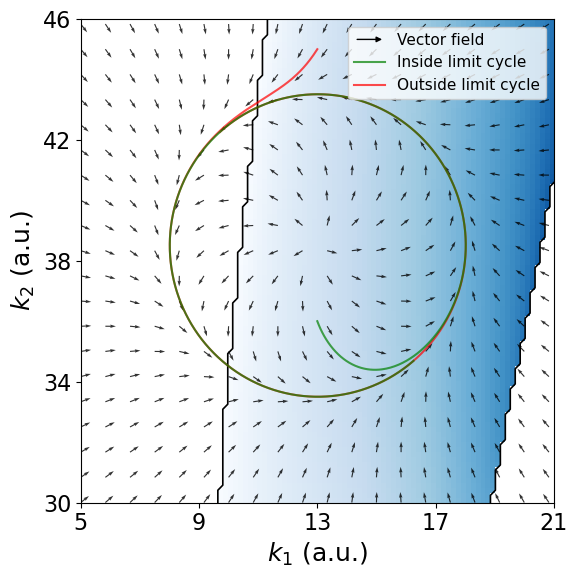

In [10]:
res1 = np.load(f"sample_TPLC.npz")

# Define parameter ranges
k1_vals = np.linspace(5, 25, 25)
k2_vals = np.linspace(30, 50, 25)

# Initialize arrays for vector field components
F1 = np.zeros((len(k2_vals), len(k1_vals)))  # Shape: (rows=k2, cols=k1)
F2 = np.zeros((len(k2_vals), len(k1_vals)))
mpl.rcParams['font.size'] = 14

# Compute vector field
for i, k2 in enumerate(k2_vals):
    for j, k1 in enumerate(k1_vals):
        f1, f2 = Net8_cycle(
            k1, k2,
            radius=5,
            speed_r=0.01,
            speed_theta=0.01,
            cent_cyc=(13, 38.5),
            tangential_noise=0,
            radial_noise=0
        )
        mag = np.sqrt(f1**2 + f2**2) + 1e-9  # avoid divide by zero
        F1[i, j] = f1 / mag
        F2[i, j] = f2 / mag

# Meshgrid for quiver plotting
K1, K2 = np.meshgrid(k1_vals, k2_vals)

# Extract trajectory
k1_traj = res1['k1']
k2_traj = res1['k2']

# Subsample for quiver arrows
skip = 40
k1_seg = k1_traj[:-1:skip]
k2_seg = k2_traj[:-1:skip]
dk1 = np.diff(k1_traj)[::skip]
dk2 = np.diff(k2_traj)[::skip]

# Normalize trajectory arrows
norm = np.sqrt(dk1**2 + dk2**2) + 1e-9
dk1_norm = dk1 / norm
dk2_norm = dk2 / norm

Z = Turing_region.copy().astype(float)

# Force all ≤ 0 values to NaN → these will be colored by "set_bad"
Z[Z <= 0] = np.nan

# Create colormap: Blues for >0, white for NaN
cmap = plt.cm.Blues.copy()
cmap.set_bad(color="white")  # NaN → white

# Continuous normalization (0 → light blue, 1 → dark blue)
norm = Normalize(vmin=0, vmax=np.max(Turing_region))
plt.figure(figsize=(6, 6))
plt.pcolormesh(X, Y, Z, shading="auto", cmap=cmap, norm=norm)
mask = ~np.isnan(Z)
plt.contour(X, Y, mask.astype(int), levels=[0.5], colors="black", linewidths=1.2)

# Plot trajectory arrows (limit cycle)

# Plot vector field
plt.quiver(K1, K2, F1, F2, color='black', alpha=0.8)

# Plot inner and outer trajectories and store line handles
line_out, = plt.plot(res_out['k1'], res_out['k2'], color='red', label='Outside limit cycle', alpha=0.7)
line_in, = plt.plot(res_in['k1'], res_in['k2'], color='green', label='Inside limit cycle', alpha=0.7)

# --- Legend Handling ---

# Custom legend arrow renderer
def make_legend_arrow(legend, orig_handle, xdescent, ydescent, width, height, fontsize):
    return FancyArrowPatch((xdescent, height / 2),
                           (width - xdescent, height / 2),
                           color=orig_handle.get_edgecolor(),
                           arrowstyle='-|>',
                           mutation_scale=8,
                           lw=2)

# Create proxy arrows for legend
arrow1 = FancyArrowPatch((0, 0), (1, 0), edgecolor='green', facecolor='green')
arrow2 = FancyArrowPatch((0, 0), (1, 0), edgecolor='black', facecolor='black')

# Combine all handles and labels
handles = [ arrow2, line_in, line_out]
labels = [ 'Vector field', 'Inside limit cycle', 'Outside limit cycle']

# Create final legend
plt.legend(handles, labels,
           handler_map={
               arrow1: HandlerPatch(patch_func=make_legend_arrow),
               arrow2: HandlerPatch(patch_func=make_legend_arrow)
           },
           loc='upper right',
           fontsize=11)

# Axis labels and limits
plt.xlim(13 - 8, 13 + 8)
plt.ylim(38 - 8, 38 + 8)
plt.xlabel(r'$k_1$ (a.u.)',fontsize = 18)
plt.ylabel(r'$k_2$ (a.u.)',fontsize = 18)
plt.xticks(ticks = [5,9,13,17,21], labels = [5,9,13,17,21],fontsize=16)
plt.yticks(ticks = [30,34,38,42,46], labels = [30,34,38,42,46],fontsize=16)
plt.tight_layout()
plt.savefig("LC_main_diagram.png")

plt.show()

# Figure 2 B
We need to find out when the limit cycle entered and left the Turing island. The following code tells you this. If the first line starts with eigenvalue became positive at _, it means your initial k1 and k2 started outside the Turing island, and vice versa.

In [11]:
res = np.load(f"sample_TPLC.npz")

b_a, v_a, k_a,a,b, k_ba, mu_a = symbols('b_a v_a k_a a b k_ba mu_a', real=True)
r_d_a = b_a + v_a * 1 / (1 + (k_a / a) ** 2) * 1 / (1 + (b / k_ba) ** 2) - mu_a * a
b_b, v_b, k_ab,a,b, mu_b = symbols('b_b v_b k_ab a b mu_b', real=True)
r_d_b = b_b + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b
r_d_a_a = diff(r_d_a, a)
r_d_a_b = diff(r_d_a, b)

r_d_b_b = diff(r_d_b, b)
r_d_b_a = diff(r_d_b, a)

params = [
    1,       # D_A: 
    25,      # D_B: 
    3500,     # V_A: 
    3500,    # V_B: 
    0.5,     # k_BA: 
    1,    # b_A: 
    1,    # b_B: 
    6,     # μ_A: 
    8       # μ_B: 
] 

mod_pars = params[2:]
D_a = params[0]
D_b = params[1] 
turing_enter = []
turing_leave = []
sharp_dec = []
lambda_max = []
for index in range(0,len(res['k1'])):
    ss_1, ss_2 = solve_ss2(res['k1'][index], res['k2'][index],params,solve_ss(res['k1'][index], res['k2'][index],params))
    values = {
        b_a: mod_pars[3],
        v_a: mod_pars[0],
        k_a: res['k1'][index],
        a: ss_1, 
        b: ss_2, 
        k_ba: mod_pars[2],
        mu_a: mod_pars[5],
        b_b: mod_pars[4],
        v_b: mod_pars[1],
        k_ab: res['k2'][index],
        mu_b: mod_pars[6]
    }
    rdaa_numeric = r_d_a_a.subs(values).evalf()
    rdab_numeric = r_d_a_b.subs(values).evalf()
    rdba_numeric = r_d_b_a.subs(values).evalf()
    rdbb_numeric = r_d_b_b.subs(values).evalf()

    J = np.array([[rdaa_numeric,rdab_numeric], [rdba_numeric, rdbb_numeric]])
    J = np.array(J, dtype=float)
    eig_val = np.linalg.eig(J)[0]
    D_a = params[0]
    D_b = params[1] 
    k_values = np.linspace(0, 2, 200)
    real_lambda = []
    prev_eig_vals = [None, None]
    for k in k_values:
        J_diff = J - np.diag([D_a * k**2, D_b * k**2])
        eig_vals = np.real(np.linalg.eigvals(J_diff))
        max_real_lambda = np.max(eig_vals)
        real_lambda.append(max_real_lambda)    
        
    lambda_max.append(max(real_lambda))
    if lambda_max[index] >= 0 and lambda_max[index - 1] <0:
        print('Eigenvalues became positive at:',index)
        turing_enter.append(index)
    elif lambda_max[index] < 0 and lambda_max[index - 1] >= 0:
        print('Eigenvalues became negative at:', index)
        turing_leave.append(index)

Eigenvalues became positive at: 3
Eigenvalues became negative at: 424


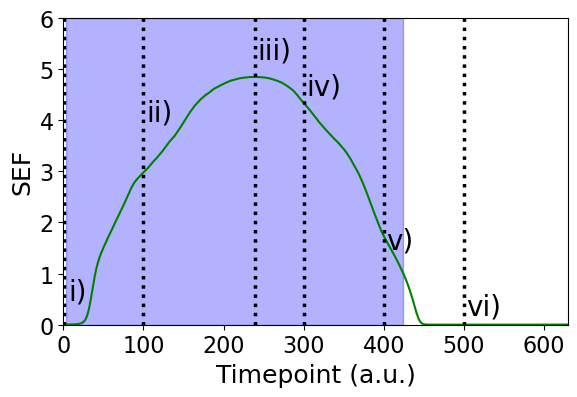

In [12]:
res = np.load(f"sample_TPLC.npz")
entropy_list = []
ss_list = []
for o in range(0,len(res['k1'])):
    FS1 = np.fft.fft2(res['u'][o], (50, 50))
    power_spectrum = np.abs(FS1) ** 2
    power_spectrum_normS1 = np.abs(FS1)**2 / np.sum(np.abs(FS1)**2)
    entropy_list.append(-np.sum(power_spectrum_normS1 * np.log2(power_spectrum_normS1+ 0.00000000000000001)))

plt.figure(figsize=(6, 4.2))
plt.plot(entropy_list,'green')
plt.axvspan(3, 424, color='blue', alpha=0.3) # Implement the numbers found in previous block
plt.ylim(0,6)
plt.xlim(0,630)
plt.axvline(x=1, color='black', linestyle=':',linewidth = 2.5)
plt.text(5 + 1, 0.5, 'i)', rotation=0, color='black', fontsize=20)

plt.axvline(x=100, color='black', linestyle=':',linewidth = 2.5)
plt.text(100+ 3, 4, 'ii)', rotation=0, color='black', fontsize=20)

plt.axvline(x=239, color='black', linestyle=':',linewidth = 2.5)
plt.text(239+ 3, 5.2, 'iii)', rotation=0, color='black', fontsize=20)

plt.axvline(x=300, color='black', linestyle=':',linewidth = 2.5)
plt.text(300+ 3, 4.5, 'iv)', rotation=0, color='black', fontsize=20)
plt.axvline(x=400, color='black', linestyle=':',linewidth = 2.5)
plt.text(400+ 3, 1.5, 'v)', rotation=0, color='black', fontsize=20)
plt.axvline(x=500, color='black', linestyle=':',linewidth = 2.5)
plt.text(500+ 3, 0.2, 'vi)', rotation=0, color='black', fontsize=20)
#plt.text(380+ 3, 0.5, 'v)', rotation=0, color='black', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('SEF', fontsize = 18)
plt.yticks([0,1,2,3,4,5,6])
plt.xlabel('Timepoint (a.u.)', fontsize = 18)
plt.tight_layout()
plt.savefig("fig2Bp1.png")
plt.show()

/var/tmp/pbs.1226174.pbs-7/ipykernel_1341477/3004277198.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space on right for colorbar


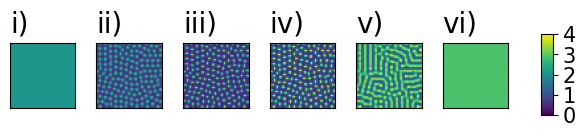

In [13]:
indices = [0,100, 239, 300, 400, 500]  # timepoint values you want to plot
labs = ['i)', 'ii)', 'iii)', 'iv)', 'v)', 'vi)']

fig, axes = plt.subplots(1, len(indices), figsize=(6, 1.8))

for ax, idx in zip(axes, range(len(indices))):
    img = ax.imshow(res['u'][indices[idx]], vmin=0, vmax=4)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Title outside, above the subplot
    ax.set_title(labs[idx], fontsize=20, loc="left", pad=8)

# Shared colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
cbar_ax = fig.add_axes([0.92, 0.28, 0.02, 0.45])  # [left, bottom, width, height]
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0, 1,2,3,4])

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space on right for colorbar

plt.savefig("fig2Bp2.png")
plt.show()


# Figure 2 C

4.3426871414968495


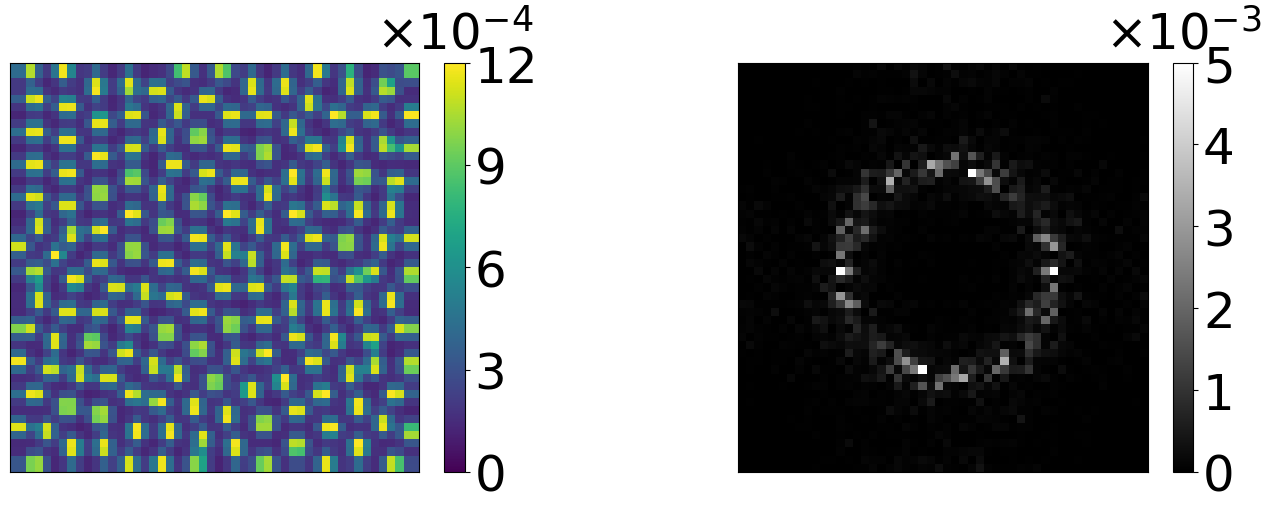

In [159]:
pattern = res['u'][300]
fon = 36
mpl.rcParams['font.size'] = fon

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
pattern_disp = pattern/np.sum(pattern)
img1 = axs[0].imshow(pattern_disp, vmin = 0, vmax = 0.0012)
cbar = plt.colorbar(img1, ax=axs[0], fraction=0.046, pad=0.04)
cbar.set_ticks([0,0.0003,0.0006,0.0009, 0.0012])
cbar.set_ticklabels(['0', '3', '6','9','12'])
cbar.ax.set_title(r'$\times 10^{-4}$', fontsize=fon, pad=10)

# axs[0].set_xticks(tick_positions)
# axs[0].set_xticklabels(tick_labels)
# axs[0].set_yticks(tick_positions)
# axs[0].set_yticklabels(tick_labels)
fft_vals = np.fft.fft2(pattern)
fft_shifted = np.fft.fftshift(fft_vals)
power_spectrum = abs(fft_shifted)**2
power_spectrum_norm = power_spectrum/np.sum(power_spectrum)

SEF = -np.sum(power_spectrum_norm * np.log2(power_spectrum_norm+ 0.00000000000000001))
power_spectrum_norm_disp = power_spectrum_norm
power_spectrum_norm_disp[25,25] = 0



img2 = axs[1].imshow(power_spectrum_norm_disp,'gray', vmin = 0,vmax = 0.005)
cbar = plt.colorbar(img2, ax=axs[1], fraction=0.046, pad=0.04)
cbar.set_ticks([0,0.001,0.002,0.003, 0.004,0.005])
cbar.set_ticklabels(['0', '1', '2','3','4','5'])
cbar.ax.set_title(r'$\times 10^{-3}$', fontsize=fon, pad=10)

plt.tight_layout()
plt.savefig('Images_for_paper/fig2C1')

print(SEF)

/var/tmp/pbs.1226174.pbs-7/ipykernel_1304927/1082095974.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([0,0.25,0.5,0.75, 1])


11.287712379549413


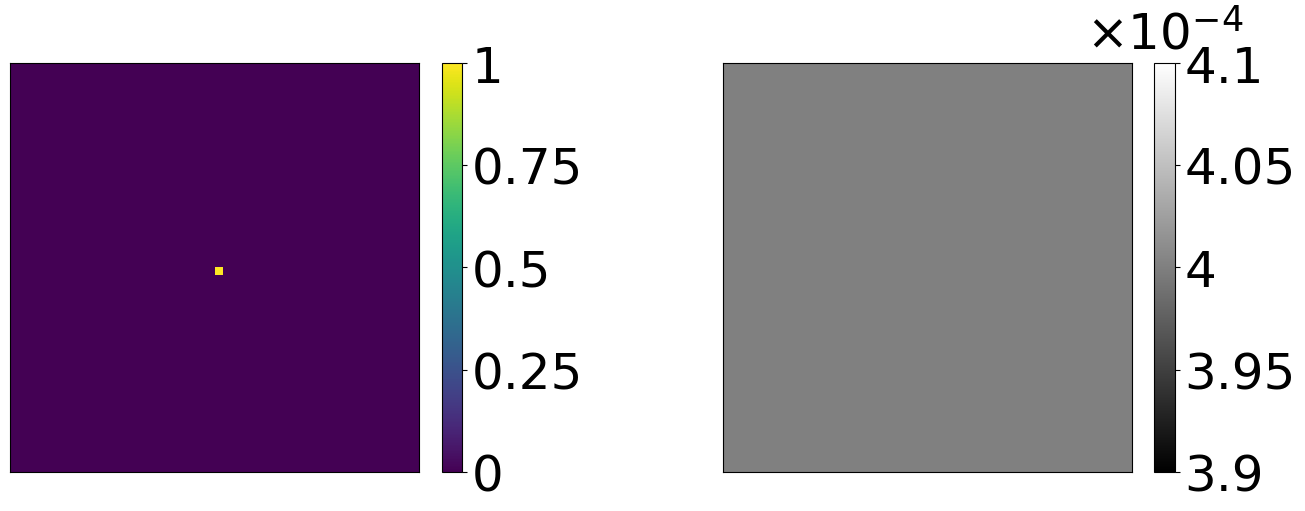

In [157]:
fon = 36
mpl.rcParams['font.size'] = fon
power_spectrum = np.reshape(np.ones(2500)*1, (50, 50))
power_spectrum_norm = power_spectrum/np.sum(power_spectrum)
magnitude = np.sqrt(power_spectrum)


real_space = np.fft.fftshift(np.fft.ifft2(magnitude).real)
pattern_disp = real_space/np.sum(real_space)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
img1 = axs[0].imshow(pattern_disp, cmap='viridis',vmin = 0,vmax = 1)
cbar = plt.colorbar(img1, ax=axs[0], fraction=0.046, pad=0.04)
cbar.set_ticklabels([0,0.25,0.5,0.75, 1])
# cbar.set_ticks(['0', '0.0025', '0.00','4.05','4.1'])

four = np.fft.fft2(pattern_disp).real
power_spectrum_norm = power_spectrum/np.sum(power_spectrum)
img2 = axs[1].imshow(power_spectrum_norm,cmap = 'gray',vmin = 0.00039,vmax = 0.00041)
cbar = plt.colorbar(img2, ax=axs[1], fraction=0.046, pad=0.04)
cbar.set_ticks([0.00039,0.000395,0.0004,0.000405, 0.00041])
cbar.set_ticklabels(['3.9', '3.95', '4','4.05','4.1'])
cbar.ax.set_title(r'$\times 10^{-4}$', fontsize=fon, pad=10)


plt.tight_layout()
plt.savefig('Images_for_paper/fig2C2')
fft_vals = np.fft.fft2(real_space)
fft_shifted = np.fft.fftshift(fft_vals)
power_spectrum = abs(fft_shifted)**2
power_spectrum_norm = power_spectrum/np.sum(power_spectrum)
power_spectrum_norm_disp = power_spectrum_norm

SEF = -np.sum(power_spectrum_norm * np.log2(power_spectrum_norm+ 0.00000000000000001))
print(SEF)

0.0025593606893167956


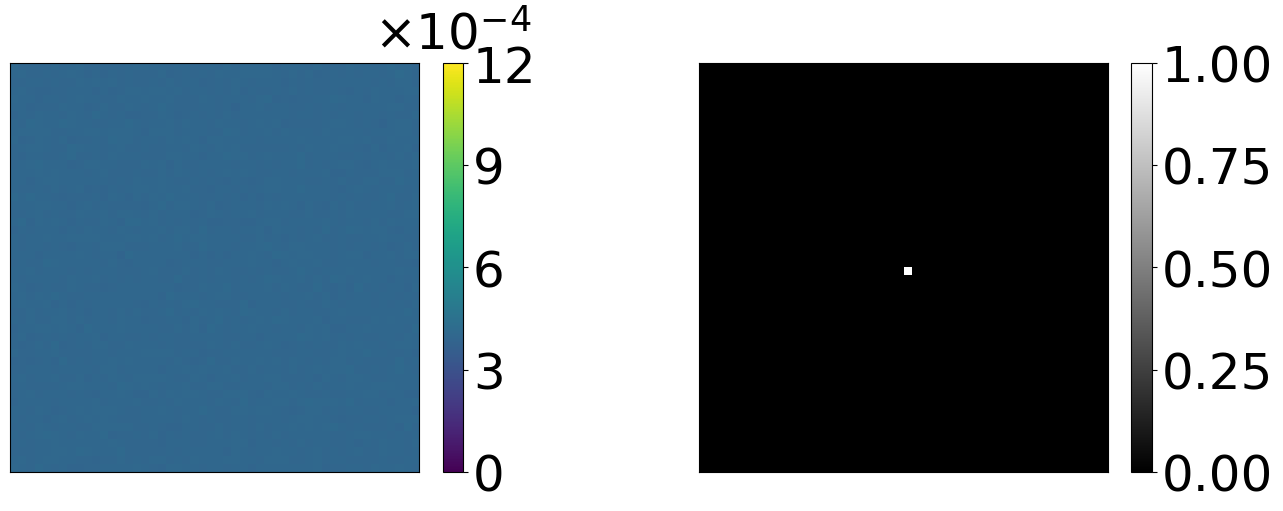

In [158]:
pattern = np.reshape(np.ones(2500)*1, (50, 50))
noise = np.random.normal(loc=0.0, scale=0.01, size=pattern.shape)

pattern = pattern + noise

pattern_disp = pattern/np.sum(pattern)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fon = 36
mpl.rcParams['font.size'] = fon

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
pattern_disp = pattern/np.sum(pattern)
img1 = axs[0].imshow(pattern_disp,vmin=0,vmax = 0.0012)
cbar = plt.colorbar(img1, ax=axs[0], fraction=0.046, pad=0.04)
cbar.set_ticks([0,0.0003,0.0006,0.0009, 0.0012])
cbar.set_ticklabels(['0', '3', '6','9','12'])
cbar.ax.set_title(r'$\times 10^{-4}$', fontsize=fon, pad=10)
tick_positions = [0,  9,  19,  29,  39,  49]
tick_labels = [1, 10,  20,  30,  40,  50]

fft_vals = np.fft.fft2(pattern)
fft_shifted = np.fft.fftshift(fft_vals)
power_spectrum = abs(fft_shifted)**2
power_spectrum_norm = power_spectrum/np.sum(power_spectrum)
power_spectrum_norm_disp = power_spectrum_norm

SEF = -np.sum(power_spectrum_norm * np.log2(power_spectrum_norm+ 0.00000000000000001))
#power_spectrum_norm_disp[25,25] = 0

img2 = axs[1].imshow(power_spectrum_norm_disp,'gray', vmin = 0, vmax = 1)
cbar = plt.colorbar(img2, ax=axs[1], fraction=0.046, pad=0.04)
cbar.set_ticks([0,0.25,0.5,0.75, 1])


plt.tight_layout()
plt.savefig('fig2C3')
print(SEF)

# Figure 2D

Mean: 0, Noise level at log(entropy)=0: 10^-3367.9061 (std dev ~ 0.00000)
Mean: 0.0001, Noise level at log(entropy)=0: 10^-4.5909 (std dev ~ 0.00003)
Mean: 0.001, Noise level at log(entropy)=0: 10^-3.5826 (std dev ~ 0.00026)
Mean: 0.01, Noise level at log(entropy)=0: 10^-2.5808 (std dev ~ 0.00263)
Mean: 0.1, Noise level at log(entropy)=0: 10^-1.5969 (std dev ~ 0.02530)
Mean: 1, Noise level at log(entropy)=0: 10^-0.5949 (std dev ~ 0.25416)
Mean: 10, Noise level at log(entropy)=0: 10^0.4218 (std dev ~ 2.64124)
Mean: 100, Noise level at log(entropy)=0: 10^1.4158 (std dev ~ 26.04920)
Mean: 1000, Noise level at log(entropy)=0: 10^2.4038 (std dev ~ 253.37053)
Mean: 10000, Noise level at log(entropy)=0: 10^3.4188 (std dev ~ 2622.91583)
Mean: 100000, Noise level at log(entropy)=0: 10^4.4125 (std dev ~ 25854.34005)


/var/tmp/pbs.1226174.pbs-7/ipykernel_1304927/2839631652.py:82: RuntimeWarning: divide by zero encountered in log10
  axes[1].plot(np.log10(means_plot), np.array(noise_cross_plot),linewidth = 6)


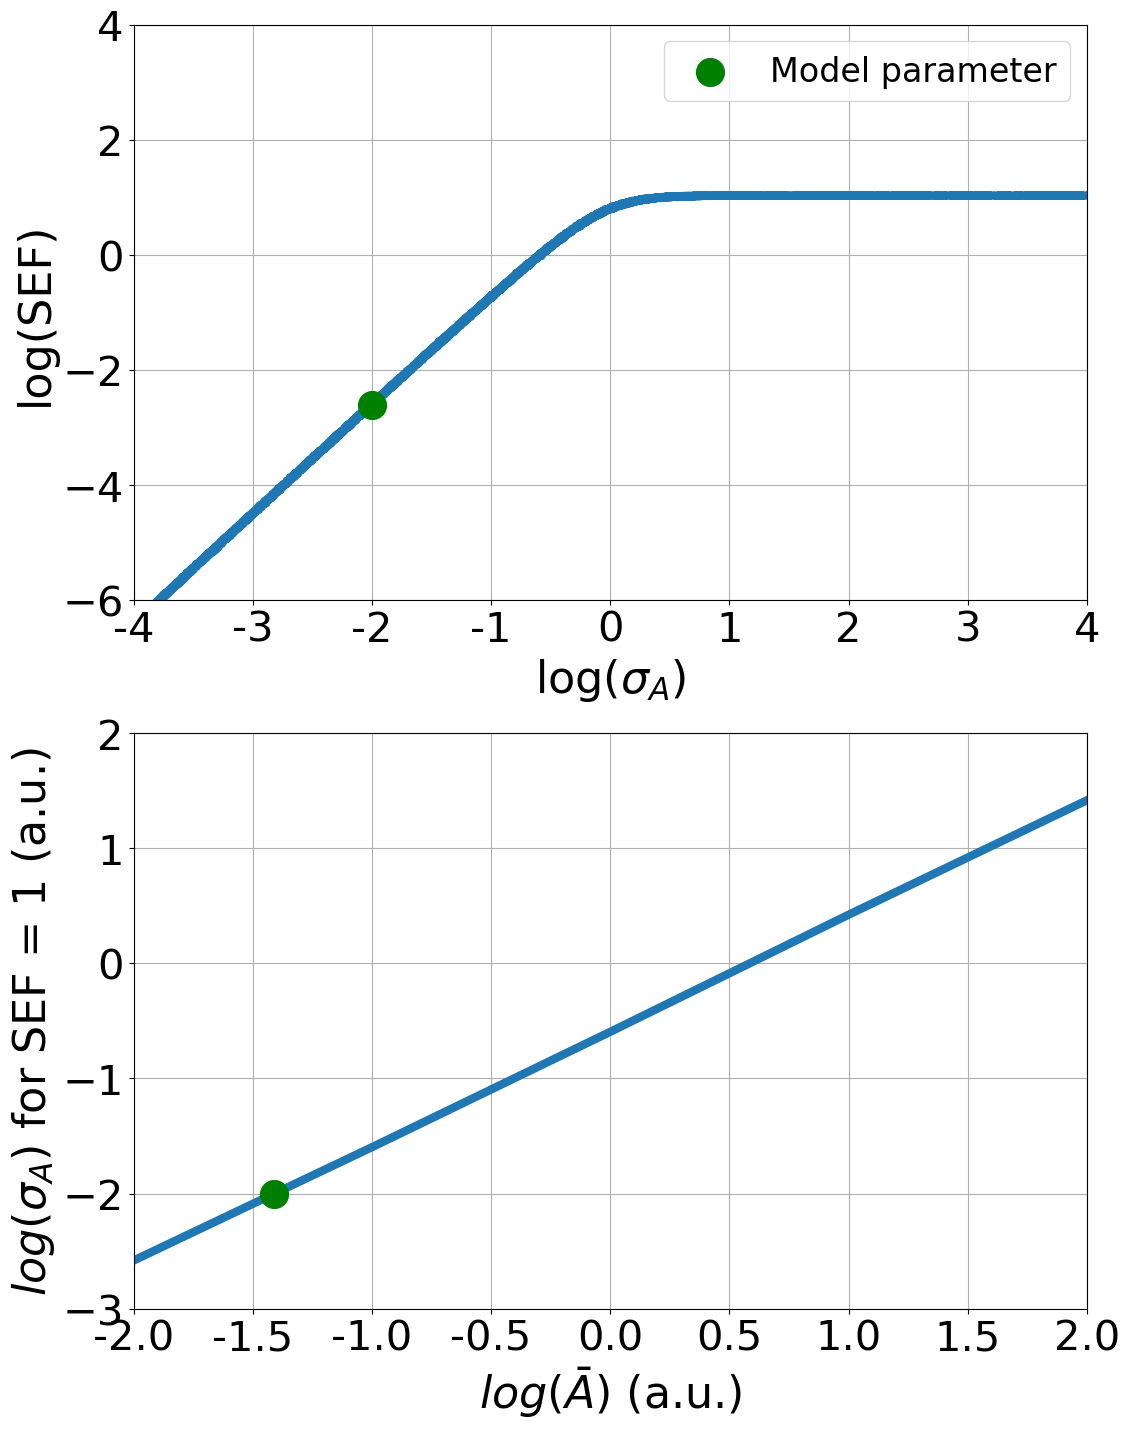

In [7]:
#Figure 2D.
#Set directory that you want to save this plot to:
fig2Ddir = "___" 
concs = np.reshape(np.ones(2500)*1, (50, 50)) # Uniform Activator concentration, mean 1.

# Initialize dictionaries and lists
conc_dict = {}
noise_list = []

# Generate concentration maps with added noise
rans = np.linspace(-5,5,10000)
for i in rans:
    noise_level = 10 ** (-i) # Exponential noise sd.
    conc_dict[noise_level] = concs + np.random.normal(0, noise_level, (50, 50)) 
    noise_list.append(noise_level)

# Calculate entropy of normalized power spectrum
ent_dict = {}
for noise in noise_list: #SEF calculation
    four_test = np.fft.fft2(conc_dict[noise], (50, 50))
    power_spectrum_norm = np.abs(four_test) ** 2 / np.sum(np.abs(four_test) ** 2)
    ent_dict[noise] = -np.sum(power_spectrum_norm * np.log2(power_spectrum_norm + 1e-16))

sorted_noises = sorted(noise_list)
lognoise = [np.log10(n) for n in sorted_noises]
logent = [np.log10(ent_dict[n]) for n in sorted_noises]


### Second half
means = [0,0.0001,0.001,0.01,0.1, 1, 10,100,1000,10000,100000]  # Example means you want to test
crossing_points = []  # To store noise level at log(entropy)=0 for each mean

rans = np.linspace(-5, 5, 10000)
noise_list = 10 ** (-rans)  # corresponding noise levels

for mean_val in means:
    concs = np.reshape(np.ones(2500) * mean_val, (50, 50))
    conc_dict = {}
    for noise_level in noise_list:
        conc_dict[noise_level] = concs + np.random.normal(0, noise_level, (50, 50))

    ent_dict = {}
    
    # SEF for each noise level
    for noise in noise_list:
        four_test = np.fft.fft2(conc_dict[noise], (50, 50))
        power_spectrum_norm = np.abs(four_test) ** 2 / np.sum(np.abs(four_test) ** 2)
        entropy = -np.sum(power_spectrum_norm * np.log2(power_spectrum_norm + 1e-16))
        ent_dict[noise] = entropy

    sorted_noises = sorted(ent_dict.keys())
    lognoise2 = np.log10(sorted_noises)
    logent2 = np.log10([ent_dict[n] for n in sorted_noises])

    # Interpolate to find where log(entropy) crosses zero
    f_interp = interp1d(logent2, lognoise2, kind='linear', bounds_error=False, fill_value='extrapolate')
    noise_at_cross = f_interp(0)  # noise level where log(entropy) = 0

    crossing_points.append((mean_val, noise_at_cross))
    

# Print results
for mean_val, noise_cross in crossing_points:
    print(f"Mean: {mean_val}, Noise level at log(entropy)=0: 10^{noise_cross:.4f} (std dev ~ {10**noise_cross:.5f})")

means_plot, noise_cross_plot = zip(*crossing_points)

fig, axes = plt.subplots(2, 1, figsize=(12, 14.4))  # 2 rows, 1 column
axes[0].plot(lognoise, logent, zorder=2,linewidth = 6)
axes[0].scatter(np.log10(0.01), -2.6101045040681763, color='green', s=400, zorder=3, label='Model parameter')
axes[0].legend(fontsize=24)
axes[0].grid(True, zorder=0)
axes[0].tick_params(axis='x', labelsize=30)
axes[0].tick_params(axis='y', labelsize=30)
axes[0].set_ylabel(r'log(SEF)', fontsize=32)
axes[0].set_xticks(np.linspace(-4,4,9), labels=np.linspace(-4,4,9,dtype = int))

axes[0].set_xlabel(r'$\log(\sigma_A)$', fontsize=32)
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-6, 4)

axes[1].plot(np.log10(means_plot), np.array(noise_cross_plot),linewidth = 6)
axes[1].scatter(-1.41,np.log10(0.01), color='green', s=400, zorder=3, label='Model parameter')
axes[1].grid(True)
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-3, 2)
axes[1].tick_params(axis='x', labelsize=30)
axes[1].tick_params(axis='y', labelsize=30)

axes[1].set_xticks(np.linspace(-2,2,9), labels=np.linspace(-2,2,9))
axes[1].set_xlabel(r'$log(\bar{A})$ (a.u.)', fontsize=32)
axes[1].set_ylabel(r'$log(\sigma_A)$ for SEF = 1 (a.u.)', fontsize=32)


plt.tight_layout(rect=[0, 0, 0.95, 1])

plt.savefig(fig2Ddir)
plt.show()